# Predicting life of components: A simple Probabilistic Crack propagation example

Predicting the life of a component that is prone to cracking is an age-old problem that has been studied ad-nauseam by the [fracture mechanics community](https://www.google.com/search?tbm=bks&q=fracture+mechanics).  [Crack propagation models](https://en.wikipedia.org/wiki/Fracture_mechanics) are at the core of Prognostics and Health Management (PHM) solutions for engineering systems and the aptly titled book [Prognostics and Health Management of Engineering Systems: An Introduction](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) provides a great example of how real world data can be used to calibrate engineering models. With the example below, we would like to motivate the use of "Hybrid models" that combine probabilistic learning techniques and engineering domain models. 

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\DeltaK = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.

Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length. 
 
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data. Such data is usually obtained during maintenance and inspections of engineering systems. In this example, we will use the sample dataset from  the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) . 
 
We will demonstrate a probabilistic calibration of $C$ and $m$ using Tensorflow Probability.

At BHGE Digital we leverage our [Depend-on-Docker](https://github.com/bhgedigital/depend-on-docker) project for automating analytics development. A sample of such automation is available [here](https://github.com/bhgedigital/bayesian_calibration), with the complete code of the example below. 

With the right automation for developing and deploying analytics in place,  we start by importing the following libraries:

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow_probability.python.mcmc import util as mcmc_util
import time
import math 

import matplotlib     
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)

font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up the data

Setting up the data for the calibration comes next. Here we leverage the dataset provided in the Table 4.2 of the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false):


In [65]:
# true values of the parameters
t = np.arange(0,1600, 100) #cycles
y = [0.0100,0.0109,0.0101,0.0107,0.0110,0.0123,0.0099,0.0113, 
   0.0132,0.0138,0.0148,0.0156,0.0155,0.0141,0.0169,0.0168] # measured crack size data

### Priors

For Bayesian calibration, we need to define the prior distributions for the calibration variables. In a real application, these priors can be informed by a subject matter expert. For this example, we will assume that both $C$ and $m$ are Gaussian and independent.


In [66]:
prio_par_C = [-23.0, 1.1] # [location, scale] for Normal Prior
prio_par_m = [4.0, 0.2] # [location, scale] for Normal Prior
rv_m = tfd.Normal(loc = 0.0, scale = 1.0, name = 'm_norm') # Random variable m definition
rv_C = tfd.Normal(loc = 0.0, scale = 1.0, name = 'C_norm') # Random variable logC definition

### Log-prob function

We have defined external parameters and standard Normal distribution for both variables, just to sample from a normalized space. Therefore, we will need to de-normalize both random variables when computing the crack model.

Now we define the joint log probability for the random variables being calibrated and the associated crack model:


In [67]:
def joint_logprob(cycles, observations, y0, C_norm, m_norm):
    # Joint logProbability function for both random variables and observations.
    # Some constants
    dsig = 75.0
    B = tf.constant(dsig*math.sqrt(math.pi), tf.float32)
    # Computing m and logC on original space
    C = C_norm*tf.sqrt(prio_par_C[1]) + prio_par_C[0] # 
    m = m_norm*tf.sqrt(prio_par_m[1]) + prio_par_m[0]
    
    # Crack Propagation model - compute in the log space
    y_model = (2.0/(2.0-m))*tf.log(cycles*tf.exp(C)*(1-m/2.0)*tf.pow(B,m) + tf.pow(y0, 1-m/2.0) )
    
    # Defining child model random variable
    rv_model = tfd.Independent(tfd.LogNormal(loc = y_model, scale = 0.1),
                                reinterpreted_batch_ndims=1, name = 'model')
    # Sum of logProbabilities
    sum_log_prob = rv_C.log_prob(C_norm) + rv_m.log_prob(m_norm) + rv_model.log_prob(observations)
    return sum_log_prob

### Sampler

Finally, it is time to set up the sampler and run a Tensorflow session:

In [68]:
# Number of samples and burnin for the MCMC sampler
samples = 12000
burnin = 8000
# Initial state for the HMC
initial_state = [0.0,0.0]
# Converting the data into tensors
cycles = tf.convert_to_tensor(t,tf.float32)
observations = tf.convert_to_tensor(y,tf.float32)
y0 = tf.convert_to_tensor(y[0], tf.float32)
# Setting up a target posterior for our joint logprobability
unormalized_target_posterior= lambda *args: joint_logprob(cycles, observations, y0, *args)
# And finally setting up the mcmc sampler
[C_samples,m_samples], kernel_results = tfp.mcmc.sample_chain(num_results= samples, num_burnin_steps= burnin,
                                                               current_state=initial_state,
                                                              kernel= tfp.mcmc.HamiltonianMonteCarlo(
                                                                      target_log_prob_fn=unormalized_target_posterior,
                                                                      step_size = 0.06, 
                                                                      num_leapfrog_steps=6))


# Tracking the acceptance rate for the sampled chain
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.is_accepted))

# Actually running the sampler
with tf.Session() as sess:
    [C_samples_, m_samples_, acceptance_rate_] = sess.run([C_samples, m_samples, acceptance_rate])

# Some initial results
print('acceptance_rate:', acceptance_rate_)

acceptance_rate: 0.7460833


### Plotting Results

If everything has gone according to plan, at this point we will see a acceptance rate of the sampler of around 60%. Pretty good for our first bayesian hierarchical crack propagation model. A key metric for the HMC sampler are the sampled chains themselves, which should look "mixed" . In this case, the sampler did a decent job as seen below: 


Text(0.5,1,'m samples')

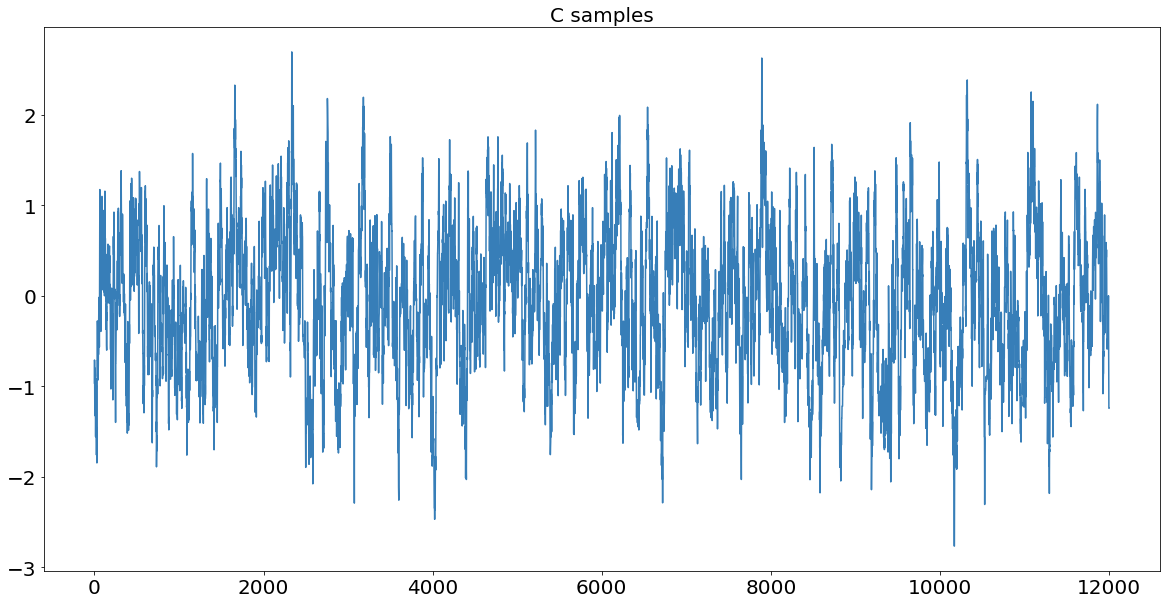

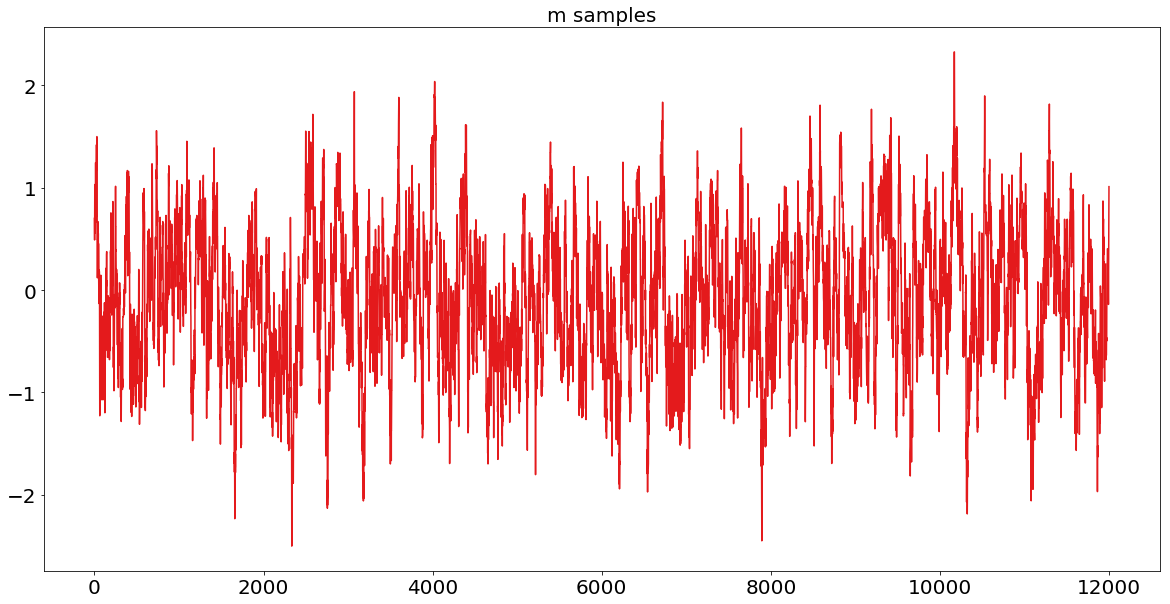

In [69]:
# plotting the mcmc chains
plt.figure(figsize=(20,10))
plt.plot(np.arange(samples), C_samples_,color='#377eb8')
plt.title('C samples',fontsize=20)

plt.figure(figsize=(20,10))
plt.plot(np.arange(samples), m_samples_,color= '#e41a1c')
plt.title('m samples',fontsize=20)



If we collect our sample and rescale them to the original space, we can get some summary statistics on the posterior estimates of the calibrated parameters $\log(C)$ and $m$ and take a look at the distributions:

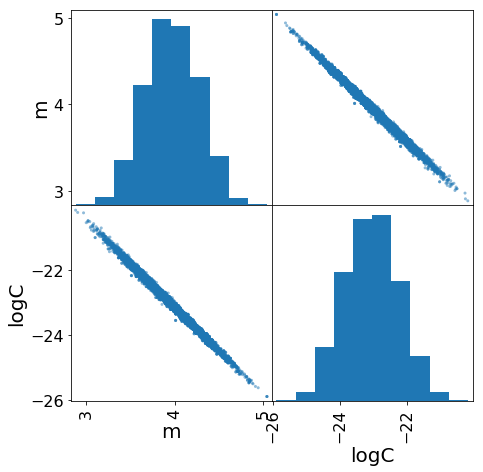

In [70]:
# Converting to proper scale
C_samples_scale = C_samples_*np.sqrt(prio_par_C[1]) + prio_par_C[0]
m_samples_scale = m_samples_*np.sqrt(prio_par_m[1]) + prio_par_m[0]
df = pd.DataFrame(np.concatenate([m_samples_scale[:,None], C_samples_scale[:,None]], axis = 1), columns = ['m', 'logC'])

ax = pd.plotting.scatter_matrix(df,figsize=(7.2,7.2))

for axi in ax:
    axi[0].tick_params(labelsize=16)
    axi[1].tick_params(labelsize=16)


It is interesting to note that although we started off with two independent Gaussian distributions for $C$ and $m$, the posterior distributions are highly correlated. This is because, the solution space dictates that for high values for m, the only physically meaningful results lie at small values of C and vice-versa. If one were to have used any number of deterministic optimization techniques to find the "best fit" for $C$ and $m$ that fits this dataset, we could end up in any value that lies on the straight line depending on our starting point and constraints. Performing a probabilsitic optimization (a.k.a. Bayesian calibration) provides us with a global view of all possible solutions that can explain the dataset.



In [71]:
df.describe(percentiles=[.05, .95])

,m,logC
count,12000.000000,12000.000000
mean,3.963806,-23.062849
std,0.302493,0.811408
min,2.881485,-25.902300
5%,3.471710,-24.382308
50%,3.963002,-23.056042
95%,4.456996,-21.736518
max,5.039995,-20.171696


### Sampling the Posterior for Prognostic

And now for the final act, we shall define a posterior function for our probabilistic crack propagation model, in order to finaly make the prognostic:

In [72]:
def posterior(C_samples, m_samples, time):
    n_s = len(C_samples)
    n_inputs = len(time)
    
    # Some Constants
    dsig = 75.0
    B = tf.constant(dsig*math.sqrt(math.pi), tf.float32)
    
    # Crack Propagation model - compute in the log space
    
    y_model = (2.0/(2.0-m_samples[None,:]))*tf.log(time[:,None]*tf.exp(C_samples[None,:])*(1-m_samples[None,:]/2.0)*tf.pow(B,m_samples[None,:]) +
                       tf.pow(y0, 1-m_samples[None,:]/2.0))
    
    #y_model = tf.convert_to_tensor(y_model, tf.float32)
    rv_model = tfd.Independent(tfd.LogNormal(loc = y_model, scale = 0.1),
                                reinterpreted_batch_ndims=1, name = 'model')
    samples = rv_model.sample(1)
    with tf.Session() as sess:
        samples_ = sess.run(samples)
    
    return samples_

In [73]:
time = np.arange(0,3000,100)
y_samples = posterior(C_samples_scale, m_samples_scale, time)[0]
print(y_samples.shape)

(30, 12000)


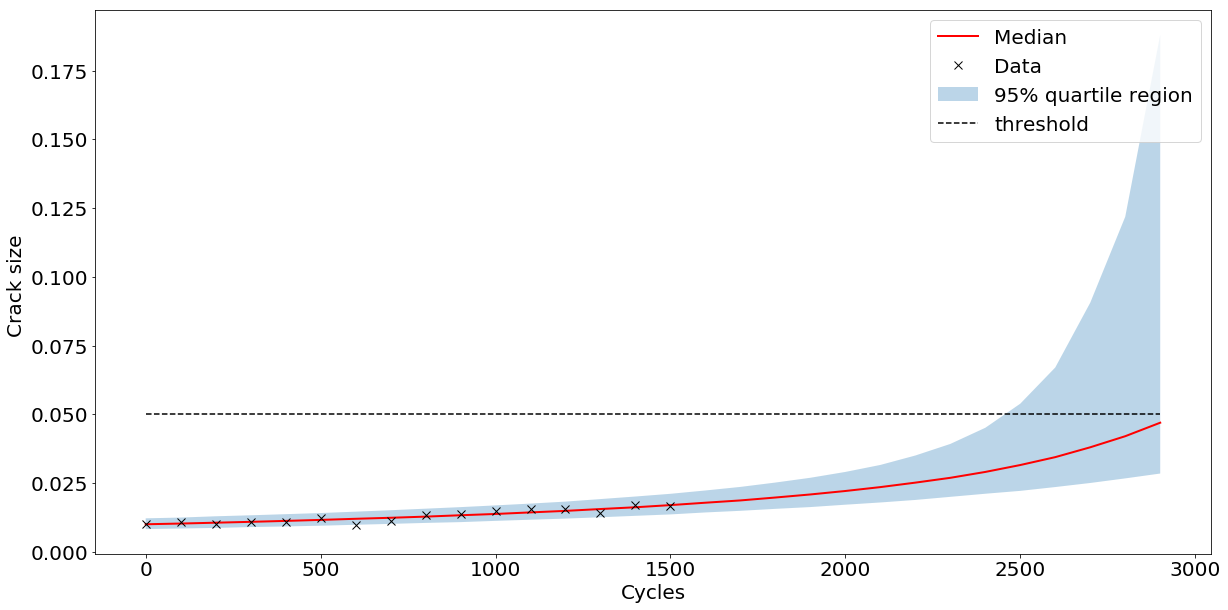

In [74]:
lower_per = np.nanpercentile(y_samples,2.5, axis = 1)
upper_per = np.nanpercentile(y_samples,97.5, axis = 1)

plt.figure(figsize =(20,10))
plt.plot(time, np.nanmedian(y_samples,axis=1), 'r', label = 'Median',linewidth=2)
plt.plot(t,y,'kx', label = 'Data',markersize=8)
plt.fill_between(time, lower_per, upper_per, label = '95% quartile region', alpha = 0.3)
plt.xlabel('Cycles')
plt.ylabel('Crack size ')
plt.hlines(0.05, np.min(time), np.max(time), linestyles = '--', label = 'threshold')
plt.legend()

The predicted mean with the 95% uncertainty bounds of crack length using the hybrid-physics probabilistic model is shown above. Clearly, the model captures both the mean behavior as well as provides an estimate of uncertainty (of the model prediction) for every time point. 

## Next steps

This is the first of a series of examples aimed at expanding the use of Probabilistic Deep Learning techniques for industrial applications. We hope you have found this useful. We would love to hear about your applications and look forward to seeing these methods used in ways that we cannot imagine. Stay tuned to this blog feed for more updates and examples on anomaly detection, missing data estimation and forecasting with variational inference.